In [13]:
import pickle
import pandas as pd
import urllib.request
import os
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj
    
data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))
data = data[["Crm Cd", "Mocodes", "Crm Cd Desc"]]
data.head(5)

,Crm Cd,Mocodes,Crm Cd Desc
0,510,NaN,VEHICLE - STOLEN
1,330,1822 1402 0344,BURGLARY FROM VEHICLE
2,480,0344 1251,BIKE - STOLEN
3,343,0325 1501,SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
4,354,1822 1501 0930 2004,THEFT OF IDENTITY


In [14]:
# 20 most common crimes
most_comma_crimes = data["Crm Cd"].value_counts()[:20]
most_comma_crimes_names = data["Crm Cd Desc"].value_counts()[:20]
rows_to_drop = []
ć = {}
for idx, crime in enumerate(data["Crm Cd"]):
    if crime not in most_comma_crimes:
        rows_to_drop.append(idx)
# remove rows that are not 20 most comma crimes   
print(most_comma_crimes_names)
print(most_comma_crimes)
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

Crm Cd Desc
VEHICLE - STOLEN                                            96751
BATTERY - SIMPLE ASSAULT                                    71648
THEFT OF IDENTITY                                           55739
BURGLARY FROM VEHICLE                                       55598
BURGLARY                                                    55206
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     54671
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              51319
THEFT PLAIN - PETTY ($950 & UNDER)                          45996
INTIMATE PARTNER - SIMPLE ASSAULT                           44910
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             34639
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         32226
ROBBERY                                                     30815
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    29936
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    23486
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    2299

In [15]:
mocodes_count = {}
rows_to_drop = [] # remove row id there is no mocode
for idx, mocodes in enumerate(data['Mocodes']):
    if pd.isna(mocodes):
        rows_to_drop.append(idx)
        continue
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in mocodes_count:
            mocodes_count[mocode] += 1
        else:
            mocodes_count[mocode] = 1
# remove rows with no mocodes
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True) 

In [16]:
# take 50 mocodes that are most comman
sorted_mocodes = dict(sorted(mocodes_count.items(), key=lambda x: x[1], reverse=True))
top_50 = dict(list(sorted_mocodes.items())[:50])
print("50 najczesciej wystepujacych mocode")
print(top_50)
# add column for 50 mocodes
for mocode in top_50:
    data[mocode] = 0
# set flag 1 if mocode occure
for idx, mocodes in enumerate(data["Mocodes"]):
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in top_50.keys():
            data.at[idx, mocode] = 1
data.drop(["Mocodes", "Crm Cd Desc"], axis=1, inplace=True)
df = data
df.head(3)

50 najczesciej wystepujacych mocode
{'1822': 263902, '0344': 242100, '0913': 120824, '0329': 112070, '0416': 108068, '1300': 78999, '2000': 66285, '0400': 61669, '1402': 42215, '2004': 41758, '1814': 40891, '1609': 37132, '0334': 36485, '1309': 32944, '0444': 32835, '1202': 31840, '0325': 31075, '1307': 29839, '0446': 25186, '0385': 22627, '0421': 21817, '0432': 21245, '1813': 20268, '1501': 20066, '0342': 19937, '0100': 19670, '0321': 19512, '0448': 18558, '1218': 18545, '0429': 18533, '1606': 17384, '0358': 17092, '0930': 16811, '0352': 16322, '0394': 14207, '0377': 14036, '0216': 13775, '1607': 13738, '0443': 13312, '0302': 13148, '1414': 12519, '0906': 12266, '0417': 12202, '2038': 12063, '0922': 11484, '0447': 11458, '1601': 11368, '0445': 11283, '1420': 11190, '0910': 10616}


,Crm Cd,1822,0344,0913,0329,0416,1300,2000,0400,1402,...,1414,0906,0417,2038,0922,0447,1601,0445,1420,0910
0,330,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,354,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,354,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = df.iloc[:, 1:]
y = df["Crm Cd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [18]:
# If there is no model - train MLP
if not os.path.exists("./models/classification_models/mlp_mocodes.pkl"):
    mlp_model = MLPClassifier()
    mlp_model.fit(X_train, y_train)
    with open('models/classification_models/mlp_mocodes.pkl','wb') as f:
        pickle.dump(mlp_model,f)
# Load model if exist
else:
    with open('models/classification_models/mlp_mocodes.pkl', 'rb') as f:
        mlp_model = pickle.load(f)
        

In [19]:
# If there is no model - train DT
if not os.path.exists("./models/classification_models/dt_mocodes.pkl"):
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    with open('models/classification_models/dt_mocodes.pkl','wb') as f:
        pickle.dump(dt_model,f)
# Load model if exist
else:
    with open('models/classification_models/dt_mocodes.pkl', 'rb') as f:
        dt_model = pickle.load(f)

In [20]:
preds_mlp = mlp_model.predict(X_test)
preds_dt = dt_model.predict(X_test)

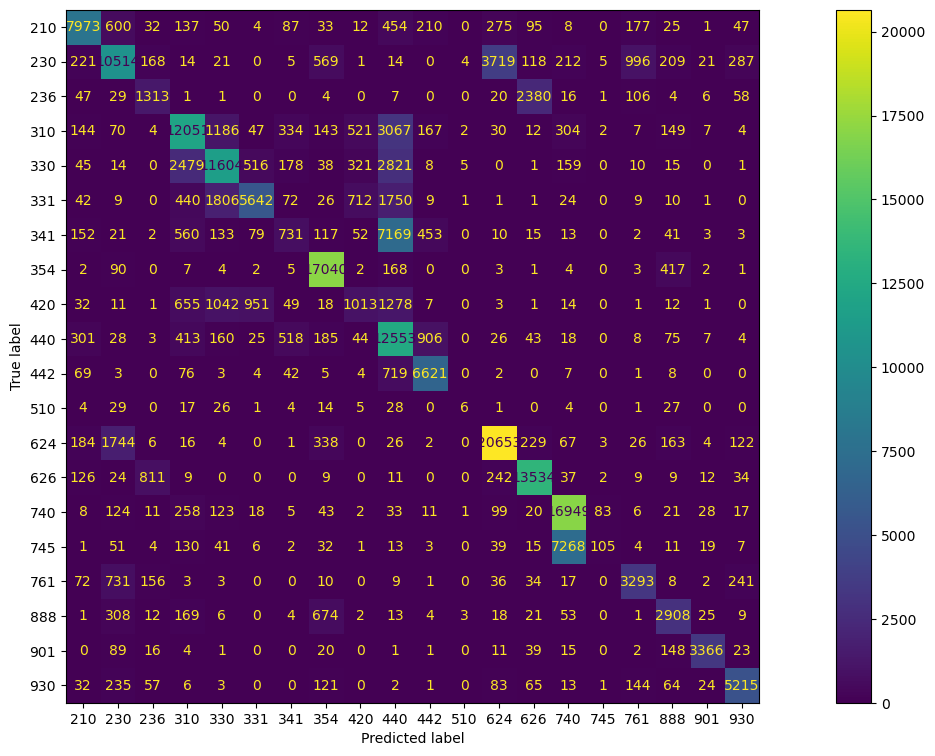

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(
y_test, preds_mlp,) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(9)  

In [22]:
print(classification_report(y_test, preds_mlp,))

              precision    recall  f1-score   support

         210       0.84      0.78      0.81     10220
         230       0.71      0.61      0.66     17098
         236       0.51      0.33      0.40      3993
         310       0.69      0.66      0.68     18251
         330       0.72      0.64      0.67     18215
         331       0.77      0.53      0.63     10555
         341       0.36      0.08      0.13      9556
         354       0.88      0.96      0.92     17751
         420       0.38      0.20      0.26      5089
         440       0.42      0.82      0.55     15317
         442       0.79      0.88      0.83      7564
         510       0.27      0.04      0.06       167
         624       0.82      0.88      0.85     23588
         626       0.81      0.91      0.86     14869
         740       0.67      0.95      0.79     17860
         745       0.52      0.01      0.03      7752
         761       0.69      0.71      0.70      4616
         888       0.67    

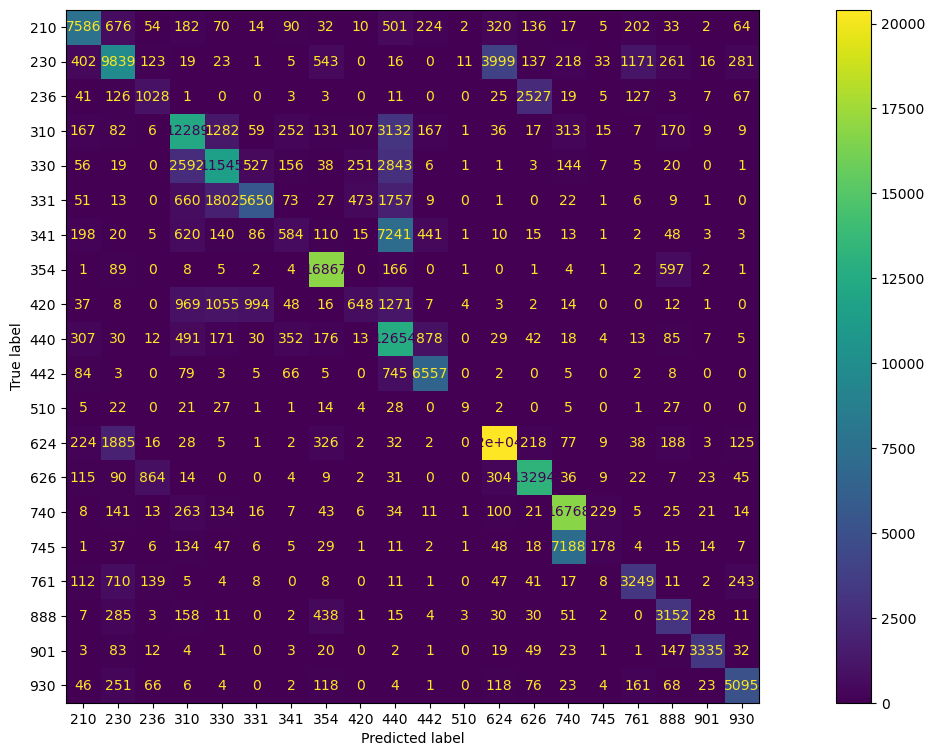

In [23]:

disp = ConfusionMatrixDisplay.from_predictions(
y_test, preds_dt, ) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(9) 

In [24]:
print(classification_report(y_test, preds_dt,))

              precision    recall  f1-score   support

         210       0.80      0.74      0.77     10220
         230       0.68      0.58      0.62     17098
         236       0.44      0.26      0.32      3993
         310       0.66      0.67      0.67     18251
         330       0.71      0.63      0.67     18215
         331       0.76      0.54      0.63     10555
         341       0.35      0.06      0.10      9556
         354       0.89      0.95      0.92     17751
         420       0.42      0.13      0.20      5089
         440       0.41      0.83      0.55     15317
         442       0.79      0.87      0.83      7564
         510       0.26      0.05      0.09       167
         624       0.80      0.87      0.83     23588
         626       0.80      0.89      0.84     14869
         740       0.67      0.94      0.78     17860
         745       0.35      0.02      0.04      7752
         761       0.65      0.70      0.67      4616
         888       0.65    